In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
import os
import tarfile
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import cv2

In [4]:
# Extract the dataset
dataset_path = '/kaggle/input/cub-200-2011-resnet80/CUB_200_2011.tgz'
extract_path = '/kaggle/working/CUB_200_2011_extracted'

with tarfile.open(dataset_path, 'r:gz') as tar:
    tar.extractall(extract_path)

In [5]:
# Load the data
images_path = os.path.join(extract_path, 'CUB_200_2011', 'images')
images_list = []
labels_list = []

with open(os.path.join(extract_path, 'CUB_200_2011', 'images.txt')) as f:
    for line in f:
        images_list.append(line.strip().split(' ')[1])

with open(os.path.join(extract_path, 'CUB_200_2011', 'image_class_labels.txt')) as f:
    for line in f:
        labels_list.append(int(line.strip().split(' ')[1]) - 1)

split_list = []
with open(os.path.join(extract_path, 'CUB_200_2011', 'train_test_split.txt')) as f:
    for line in f:
        split_list.append(int(line.strip().split(' ')[1]))

In [6]:
# Preprocess the data
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))  # EfficientNetB0 input size
    img = preprocess_input(img)  # Preprocess for EfficientNetB0
    return img

X = np.array([load_and_preprocess_image(os.path.join(images_path, img_path)) for img_path in images_list])
y = np.array(labels_list)


In [7]:
# Use the provided split
X_train = X[np.array(split_list) == 1]
X_test = X[np.array(split_list) == 0]
y_train = y[np.array(split_list) == 1]
y_test = y[np.array(split_list) == 0]

y_train = to_categorical(y_train, num_classes=200)
y_test = to_categorical(y_test, num_classes=200)

In [8]:
# Define the model using EfficientNetB0
base_model = EfficientNetB0(weights='/kaggle/input/efficientnetb0/keras/default/1/efficientnetb0_notop.h5', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

In [9]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(200, activation='softmax')
])

# Build the model to initialize weights
model.build((None, 224, 224, 3))

# Ensure the model has fewer than 10M parameters
assert model.count_params() < 10_000_000, "The model exceeds 10 million parameters"

# Print model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │       102,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,808,043 (18.34 MB)

 Trainable params: 758,472 (2.89 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [10]:
# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [11]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [12]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [13]:
# Train the model
batch_size = 32
epochs = 30

history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=epochs,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])

# Save the model
# model.save('/kaggle/working/fine_grained_cnn_model.h5')

Epoch 1/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 575s 3s/step - accuracy: 0.0521 - loss: 4.9560 - val_accuracy: 0.2849 - val_loss: 3.0316 - learning_rate: 0.0010
Epoch 2/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 243s 1s/step - accuracy: 0.1562 - loss: 3.4201 - val_accuracy: 0.2837 - val_loss: 3.0246 - learning_rate: 0.0010
Epoch 3/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 512s 3s/step - accuracy: 0.2541 - loss: 3.1581 - val_accuracy: 0.4279 - val_loss: 2.3091 - learning_rate: 0.0010
Epoch 4/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.2188 - loss: 3.2937 - val_accuracy: 0.4285 - val_loss: 2.3040 - learning_rate: 0.0010
Epoch 5/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 544s 3s/step - accuracy: 0.3552 - loss: 2.4908 - val_accuracy: 0.4643 - val_loss: 2.0266 - learning_rate: 0.0010
Epoch 6/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - accuracy: 0.4062 - loss: 2.2165 - val_accuracy: 0.4646 - val_loss: 2.0257 - learning_rate: 0.0010
Epoch 7/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 538s 3s/step - accuracy: 0.4276 - loss: 2.

In [16]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

182/182 - 228s - 1s/step - accuracy: 0.5935 - loss: 1.5528
Test accuracy: 59.35%


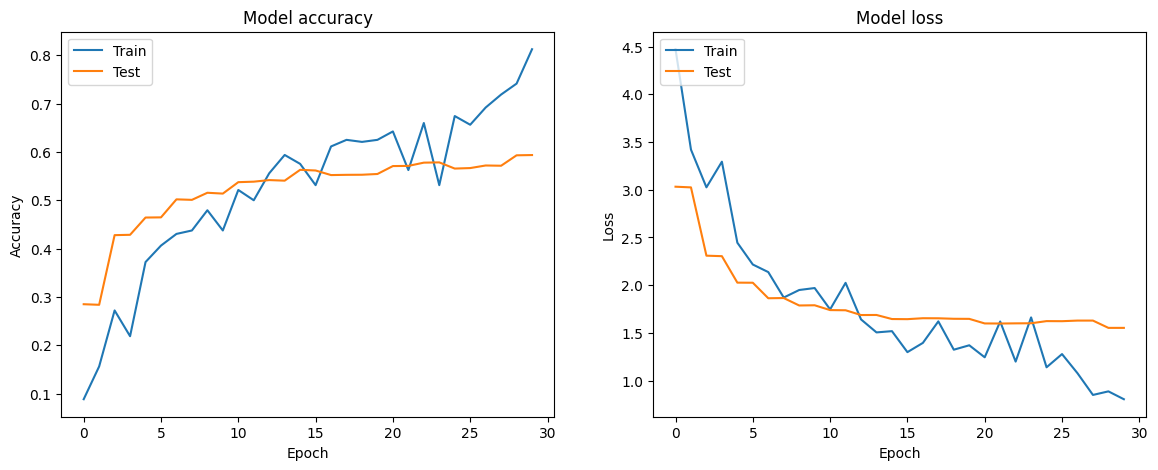

In [17]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()